# Group Work Assignment Submission 2 - Group 6B
The goal of Submission 2 is to price a vanilla European call option, except we will now allow the volatility term to vary. For this submission, complete the following tasks:
1. Using a simple Fourier pricing technique (using $N = 100$ intervals, and using an effective upper bound of integration of $30$), price a vanilla call option assuming that the underlying share follows the Heston model dynamics. Use the parameter values from the previous section, as well as the following parameter values:
 * $v_0 = 0.06$
 * $\kappa = 9$
 * $\theta = 0.06 $
 * $\rho = -0.4$ 
We will now simulate a share price path.
1. Assume that $\sigma(t_i , t_{i+1} ) = \sigma(S_{t_i} )^{\gamma-1}$ , where $\sigma = 0.3$ and $\gamma = 0.75$ . Using the formula below, simulate paths for the underlying share using sample sizes of 1000, 2000, ..., 50000. Perform monthly simulations for a period of a year. We can simulate the next step in a share price path using the following formula:
$$ S_{t_{i+1}}=S_{t_i}e^{(r-\frac{\sigma^2(t_i,t_{i+1})}{2})(t_{i+1}-t_i)+\sigma(t_i,t_{i+1})\sqrt{t_{i+1}-t_i}Z} $$
where $S_{t_i}$ is the share price at time $t_i$, $\sigma(t_i, t_{i+1})$ is the volatility for the period $[t_i, t_{i+s}]$, $r$ is the risk-free interest rate, and $Z \sim N(0,1)$.
Note that we are attempting to run simulations using the CEV model. However, while the CEV model assumes that volatility is a continuous function of time and share price, we are making a simplifying assumption that volatility is constant over each simulation period.
1. Augment your code in part 2 to calculate Monte Carlo estimates, as well as the standard deviations for these estimates, for the price of a vanilla call option (with the same strike term as in Submission 1).
1. Plot the Monte Carlo estimates generated in part 3 with respect to sample size, as well as
three standard deviation error bounds around these estimates.

### Part 0, Import libraries and Setting share and option parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import ncx2

# share info
S0 = 100    # from submission 1
risk_free_rate = 0.08    # from submission 1
sigma_share = 0.3     # from submission 1

# option info
T = 1
K = S0

# Heston Model relevant
v0 = 0.06
kappa = 9
theta = 0.06
rho = -0.4
sigma_vol = sigma_share  # as asked to use the sigma from submission 1

### Part 1, Pricing with Heston Model

The Heston Model assumes the asset follows 
$$ dS_t = \mu S_t dt +\sqrt{v_t}S_tdW_t^1$$
and the volatility term $v_t$ follows a CIR, or square-root process
$$d\sqrt{v_t} =-\beta \sqrt{v_t} dt + \sigma dW_t^2 $$ 
where $W_t^2$ is a  standard Brownian motion and has correlation $\rho$ with $W_t^1$. 
The characteristic function of $s_t = log(S_t)$ can be written as
$$ \phi_{s_T} =exp(C(\tau ;u)+D(\tau ; u)v_t +iulog(S_t))$$
where $$C(\tau; u)=ri\tau u +\theta\kappa\left[\tau x_--\frac{1}{a}log\left(\frac{1-ge^{d\tau}}{1-g}\right)\right] $$
$$ D(\tau;u) =\left(\frac{1-e^{-d\tau}}{1-ge^{-d\tau}}\right)x_- $$
and
$$\tau = T-t$$
$$ g = \frac{x_-}{x_+}$$
$$ x_{\pm} =\frac{b\pm d}{2a} $$
$$d = \sqrt{b^2-4ac} $$
$$ c=-\frac{u^2+ui}{2}$$
$$ b=\kappa-\rho\sigma iu$$
$$a=\frac{\sigma^2}{2}$$
Then the pricing can be done with characteristic functions
$$c=S_0\left(\frac{1}{2} +\frac{1}{\pi}\int_0^{\infty} \frac{Im[e^{-it\mathrm{ln}K}\varphi_{M_2}(t)]}{t}dt  \right) - e^{-rT}K\left(\frac{1}{2}+\frac{1}{\pi}\int_0^{\infty} \frac{Im[e^{-it\mathrm{ln}K}\varphi_{M_1}(t)]}{t}dt \right)$$
where
$$ \varphi_{M_1}(t)=\phi_{s_T}(t) $$
$$\varphi_{M_2}(t) = \frac{\phi_{s_T}(u-i)}{\phi_{s_T}(-i)}$$

In [2]:
# First we define a few functions used in Hestion model pricing, 
# function names should indicate corresponding quantities in Hestion Model

a = sigma_vol**2/2

def b(u):
    return kappa - rho*sigma_vol*1j*u

def c(u):
    return -(u**2+1j*u)/2

def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))

def xminus(u):
    return (b(u)-d(u))/(2*a)

def xplus(u):
    return (b(u)+d(u))/(2*a)

def g(u):
    return xminus(u)/xplus(u)

def C(u):
    '''Heston Model price.'''
    val = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return risk_free_rate*T*1j*u + theta*kappa*val

def D(u):
    numer = 1-np.exp(-T*d(u))
    denom = 1-g(u)*np.exp(-T*d(u))
    return (numer/denom)*xminus(u)

def phi_M1(u):
    '''Characteristic function of s_T in Heston Model.'''
    return np.exp(C(u) + D(u)*v0 + 1j*u*np.log(S0))

def phi_M2(u):
    return phi_M1(u-1j)/phi_M1(-1j)

After choosing suitable upper bound and interval, the integrals are estimated by
$$\int_0^{\infty} \frac{Im[e^{-it\mathrm{ln}K}\varphi_{M}(t)]}{t}dt \approx  \sum_{n=1}^{N}\frac{Im[e^{-it_n\mathrm{ln}K}\varphi_M(t_n)]}{t_n}\Delta t$$

In [3]:
# setting integration parameters
t_max = 30
N = 100
log_k = np.log(K)

# generate sample points
delta_t = t_max/N
points = np.linspace(1,N,N)
t_n = (points-1/2)*delta_t

# estimating integrals by midpoint rule
integral_1 = sum((((np.exp(-1j*t_n*log_k)*phi_M2(t_n)).imag)/t_n)*delta_t)
integral_2 = sum((((np.exp(-1j*t_n*log_k)*phi_M1(t_n)).imag)/t_n)*delta_t)

# finally the Europeann call price
call_price = S0*(1/2+integral_1/np.pi) - np.exp(-risk_free_rate*T)*K*(1/2+integral_2/np.pi)

print("Heston Model Call Price: ", call_price)

Heston Model Call Price:  13.734895692109063


### Part 2, share price path under CEV model

The share price under CEV model can be written as, based on the conditions given,
$$ S_{t_{i+1}}=S_{t_i}e^{(r-\frac{\sigma^2(S_{t_i})^{2\gamma-2}}{2})\Delta t+\sigma (S_{t_i})^{\gamma-1}\sqrt{\Delta t}Z} $$
where $\Delta t=t_{i+1}-t_i$, $\sigma=0.3$, $\gamma=0.75$, and $Z\sim N(0,1)$.
The share price path can be generated progressively.

In [4]:
# parameters for CEV model 
sigma_CEV = 0.3
gamma = 0.75
delta_t = 1/12

# determine N samples of share price upto time t
def share_price_path(t, N):
    '''Generate N share price path upto time t.'''
    n = int(t/delta_t)
    Z = norm.rvs(size =[N, n])
    price_path = np.array([[np.float64(S0)]*(n+1)]*N)
    for i in range(n):
        vol = sigma_CEV*price_path[:,i]**(gamma-1)
        power = (risk_free_rate-vol**2/2)*delta_t+vol*np.sqrt(delta_t)*Z[:,i]
        price_path[:,i+1]=price_path[:,i]*np.exp(power)
    return price_path

In [5]:
# setting random seed for price path sampling
np.random.seed(10)

# sample price path with various sample size
share_price_T = [None]*50  # expectation of share price at time T
vol_share = [None]*50     # volatility of share price

for i in range(1,51):
    samples = share_price_path(T, i*1000)
    share_price_T[i-1] = np.mean(samples[:,-1])
    vol_share[i-1] = np.std(samples[:, -1])/np.sqrt(i*1000)
    

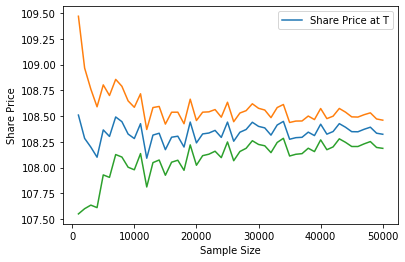

In [6]:
# ploting expection of share price at time T
plt.plot(np.array(range(1,51))*1000, share_price_T, label="Share Price at T")
plt.plot(np.array(range(1,51))*1000, [a+3*b for a,b in zip(share_price_T, vol_share)] )
plt.plot(np.array(range(1,51))*1000, [a-3*b for a,b in zip(share_price_T, vol_share)] )
plt.xlabel('Sample Size')
plt.ylabel('Share Price')
plt.legend()
plt.show()

### Part 3, Pricing a vanilla call option under CEV model

The price of call option under CEV is readily available once we sampled all price path and calculated the payoff.

In [7]:
# reset the random seed, so that the sampled price paths can be compared to that in Part 2
np.random.seed(10)

# we reuse some code from Part 2
def call_price_and_stddev(t, N):
    '''Calculate vanilla European call option price and standard deviation under CEV model,
    with maturity t, and N sample paths.'''
    smpls = share_price_path(t, N)
    pay_off = np.maximum(smpls[:, -1]-K, 0)
    return np.mean(pay_off), np.std(pay_off)/np.sqrt(N)

In [8]:
# calculating call price, with maturity T
call_price = [None]*50
call_stddev = [None]*50

for i in range(1, 51):
    call_price[i-1], call_stddev[i-1] = call_price_and_stddev(T, i*1000)

For purpose of comparison, here we also implement a closed-form solution for the call price. The closed-form call option price under CEV model defined as
$$ dS_t = \mu S_t dt + S_t \sigma(S_t, t) dW_t$$
where $$ \sigma(S_t, t) =\sigma S_t^{\gamma-1}$$
is given by
$$ C(S_0, K, T, \sigma, \gamma) =-S_0\chi(y;z,x)+Ke^{-rT}(1-\chi(x; z-2, y)) $$
where $\chi(l; m, n)$ is the cumulative distribution function of a noncentral chi-squared distribution with $m$ degrees of freedom and non-centrality parameter $n$. And
$$x=\kappa S_0^{2(1-\gamma)}e^{2r(1-\gamma)T}$$
$$ y=\kappa K^{2(1-\gamma)}$$
$$ z = 2+\frac{1}{1-\gamma}$$
$$ \kappa = \frac{2r}{\sigma^2(1-\gamma)(e^{2r(1-\gamma)T}-1)}$$

In [9]:
# closed-form call option price under CEV
z = 2+1/(1-gamma)
def closed_form_call_price(t):
    '''Call option price under CEV with maturity t'''
    kappa = 2*risk_free_rate/(sigma_CEV**2*(1-gamma)*(np.exp(2*risk_free_rate*(1-gamma)*t)-1))
    x = kappa*S0**(2*(1-gamma))*np.exp(2*risk_free_rate*(1-gamma)*t)
    y = kappa*K**(2*(1-gamma))
    return S0*(1-ncx2.cdf(y,z,x))-K*np.exp(-risk_free_rate*t)*ncx2.cdf(x,z-2,y)

### Part 4, Plotting

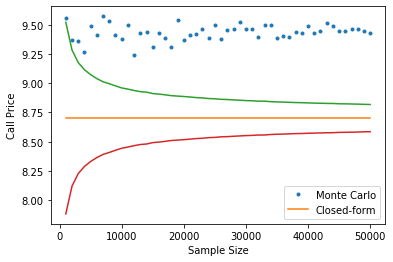

In [10]:
# plot call option price
plt.plot(np.array(range(1,51))*1000, call_price, '.', label="Monte Carlo")
plt.plot(np.array(range(1,51))*1000, [closed_form_call_price(T)]*50, label="Closed-form")
plt.plot(np.array(range(1,51))*1000, [closed_form_call_price(T)+3*s for s in call_stddev])
plt.plot(np.array(range(1,51))*1000, [closed_form_call_price(T)-3*s for s in call_stddev])
plt.xlabel("Sample Size")
plt.ylabel("Call Price")
plt.legend()
plt.show()

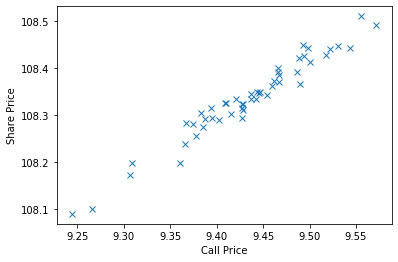

In [11]:
plt.plot(call_price, share_price_T, 'x')
plt.xlabel("Call Price")
plt.ylabel("Share Price")
plt.show()

In [12]:
# call price is highly correlated with share price, as expected
np.corrcoef(call_price, share_price_T)

array([[1.        , 0.97609681],
       [0.97609681, 1.        ]])